## Flights Agg analysis - STLmap and noavx configurations

First, let's start with the basics:


Setup:
- Single `m5.large` instance
- everything run single-threaded-
- C++ dummy code using csvmonkey parser
- run over full flight data (from 1987 - 2021).

For time reasons, only analyze 2003 because the change in specialized/general occurs in May 2003

So let's crunch the numbers.

THESE SHOWN HERE ARE WITH PRELOADING THE CSV TO MEMORY FIRST.

In [1]:
!tar xf results-agg-experiment-noavx.tar.gz && tar xf results-agg-experiment-stlmap.tar.gz

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import os
import json

In [3]:
def load_to_df(logs_path, name=None, drop_first_run=True):
    paths = glob.glob(os.path.join(logs_path, '*.txt'))
    rows = []
    for path in paths:
        try:
            name = os.path.basename(path)
            t = name[:name.find('-run')].replace('flights-', '')
            r = int(name[name.find('run-')+4:name.rfind('-date')])

            yearmonth = int(name[name.find('date-')+5:].replace('.txt', ''))
            year = yearmonth // 100
            month = yearmonth % 100
            row = {'type' : t, 'run' : r, 'year' : int(year), 'month' : int(month)}

            with open(path, 'r') as fp:
                lines = fp.readlines()

            row.update({'t_' + k : v for k, v in json.loads(lines[-1]).items()})
            rows.append(row)
        except Exception as e:
            print('ERROR: {}'.format(path))
    df = pd.DataFrame(rows)
    
    if drop_first_run:
        # drop the first run, important because it's loading the file from EBS to RAM
        df = df[df['run'] != 1]
    
    if name is not None:
        df['name'] = name
    return df

In [4]:
df_stlmap = load_to_df('results-agg-experiment-stlmap/logs/', 'stlmap')
df_noavx = load_to_df('results-agg-experiment-noavx/logs/', 'noavx')

In [5]:
def plot_df(df):
    gdf = df.groupby(['type', 'year', 'month']).mean().reset_index()
    gdf = gdf.sort_values(by=['year', 'month', 'type']).reset_index(drop=True)

    gdf_general = gdf.iloc[::2]
    gdf_special = gdf.iloc[1::2]
    
    
    # plot vertical line showing the flip
    idx_val = gdf_general[(gdf_general['year'] == 2003) & (gdf_general['month'] == 6)].index[0]
    num_offset = len(gdf_general[gdf_general.index < idx_val])

    plt.figure(figsize=(10, 5))
    plt.grid()
    plt.ylabel('transform time in ms')
    plt.xlabel('file')
    plt.plot(np.arange(len(gdf_general)), gdf_general['t_transform'] * 1000, marker='x', alpha=.5, label='general')
    plt.plot(np.arange(len(gdf_special)), gdf_special['t_transform'] * 1000, marker='o', alpha=.5, label='specialized')
    
    plt.axvline(num_offset + .5, color='k', linestyle='--')
    
    plt.legend(loc='best')

    #plt.ylim(0, 200)

Text(0.5, 1.0, 'general vs. specialized STLmap')

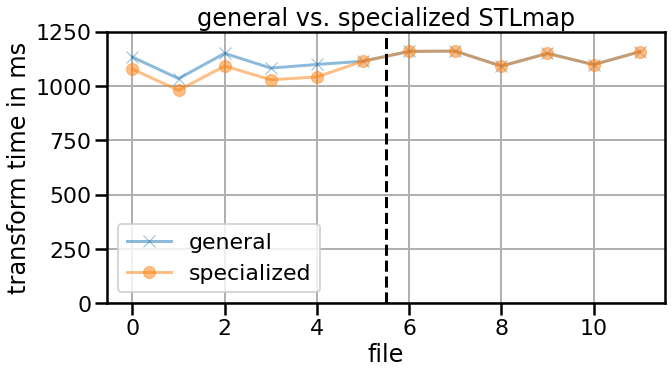

In [6]:
sns.set_context('poster')
plot_df(df_stlmap)
plt.ylim(0, 1250)
plt.title('general vs. specialized STLmap')

In [7]:
df_stlmap

,type,run,year,month,t_output,t_transform,t_total,name
0,general,7,2003,7,0.000111,1.15465,1.154760,flights-specialized-run-4-date-200302.txt
1,specialized,9,2003,11,0.000103,1.09390,1.094000,flights-specialized-run-4-date-200302.txt
2,specialized,9,2003,5,0.000106,1.04489,1.045000,flights-specialized-run-4-date-200302.txt
3,general,8,2003,11,0.000125,1.10008,1.100210,flights-specialized-run-4-date-200302.txt
4,general,8,2003,5,0.000110,1.09626,1.096370,flights-specialized-run-4-date-200302.txt
...,...,...,...,...,...,...,...,...
235,general,8,2003,8,0.000111,1.15853,1.158650,flights-specialized-run-4-date-200302.txt
236,specialized,9,2003,8,0.000104,1.16019,1.160290,flights-specialized-run-4-date-200302.txt
237,specialized,3,2003,6,0.000104,1.11367,1.113770,flights-specialized-run-4-date-200302.txt
238,specialized,3,2003,12,0.000118,1.15524,1.155360,flights-specialized-run-4-date-200302.txt


Text(0.5, 1.0, 'general vs. specialized AVX disabled')

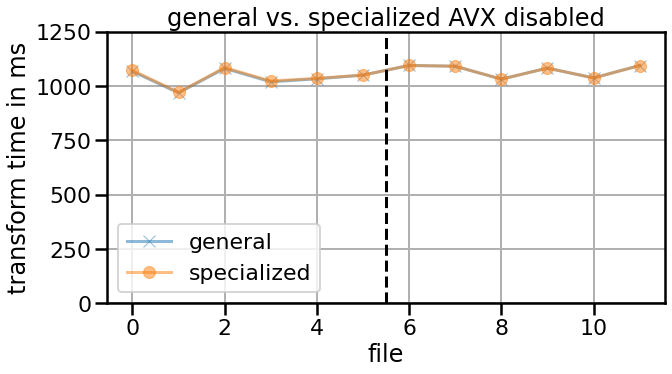

In [8]:
sns.set_context('poster')
plot_df(df_noavx)
plt.ylim(0, 1250)
plt.title('general vs. specialized AVX disabled')

to understand a bit better what's going, let's also plot here the file sizes:

Text(0.5, 0, 'file')

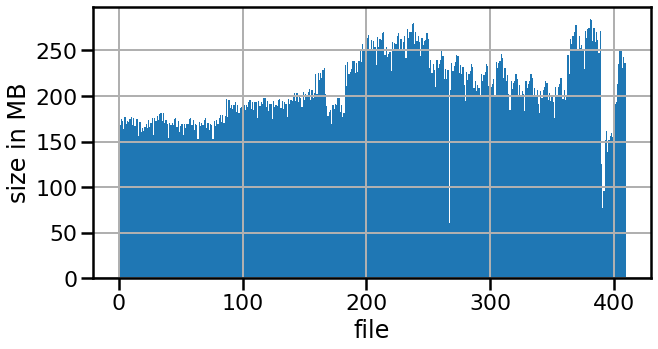

In [9]:
with open('flight_data_sizes.tsv', 'r') as fp:
    lines = filter(lambda line: len(line.strip()) > 0, fp.readlines())
lines = list(map(lambda parts: (int(parts[4]), parts[-1].strip()),
             map(lambda line: [x for x in line.split(' ') if len(x) > 0], lines)))

sizes = np.array([info[0] for info in lines])
sizes_in_mb = sizes / 1024 / 1024

plt.figure(figsize=(10, 5))
plt.grid()
plt.bar(np.arange(len(sizes_in_mb)), sizes_in_mb, width=1.)
plt.ylabel('size in MB')
plt.xlabel('file')

Looking at the numbers there's basically no significant difference.

(note: for time reasons above numbers are averages of 2 runs only)

In [10]:
# how much faster is specialized total vs. rest? 

def calc_speedup(df):
    
    # calculate mean speedup!
    
    
    g_t = df[df['type'] == 'general']['t_transform'].sum()
    s_t  = df[df['type'] == 'specialized']['t_transform'].sum()
    
    return 'specialized:\t{:.2f}s\ngeneral:\t{:.2f}s\nspeedup:\t{:.2f}x'.format(s_t, g_t, g_t / s_t)

print('STL map:\n---\n{}'.format(calc_speedup(df_stlmap)))
print()
print('STL map (pre 2003/6):\n---\n{}'.format(calc_speedup(df_stlmap[df_stlmap['month'] < 6])))
print()
print('No AVX:\n---\n{}'.format(calc_speedup(df_noavx)))

STL map:
---
specialized:	118.29s
general:	120.80s
speedup:	1.02x

STL map (pre 2003/6):
---
specialized:	46.95s
general:	49.46s
speedup:	1.05x

No AVX:
---
specialized:	126.58s
general:	126.42s
speedup:	1.00x


---
(c) 2017 - 2022 Tuplex authors